In [1]:
# Data handling
import pandas as pd
import numpy as np

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Advanced AI/mortgage.csv')

df = df.drop(columns=['FMOD_DTE','FMOD_UPB','FCE_DTE','FCE_UPB','F180_DTE','F180_UPB','PRIN_FORG_UPB',
                      'FCC_DTE','ZB_DTE', 'LPI_DTE','RMW_PROCS','DISP_DT','FCC_COST','PP_COST','AR_COST',
                      'IE_COST','TAX_COST','NS_PROCS','CE_PROCS','O_PROCS','NON_INT_UPB'],axis=1)
df['REPCH_FLAG'] = df['REPCH_FLAG'].fillna('Y')
df['TRANSFER_FLAG'] = df['TRANSFER_FLAG'].fillna('Y')

#Change the vairable to binary vairbale
df['CSCORE_CB'] = np.where(df['CSCORE_C'].isnull(),0,1)
df = df.drop(['CSCORE_C'],axis=1)

#Zero Balance
df['Zero.Bal.Code'] = np.where(df['Zero.Bal.Code'].isnull(),0,1)

#Mortgage insurance percentage
df['MI_PCT'] = df['MI_PCT'].fillna(0)

df = df.drop(columns=['MI_TYPE','Servicer.Name'],axis=1)

#NUM_BO Fill na with mode   
#DTI fill na with mean
#LAST_UPB fill na with 0 
df['NUM_BO'] = df['NUM_BO'].fillna(df['NUM_BO'].mode()[0])
df['DTI'] = df['DTI'].fillna(df['DTI'].mean())
df['LAST_UPB'] = df['LAST_UPB'].fillna(0)

drop = ['Unnamed: 0','V1','LOAN_ID','ZIP_3','MSA', # meaningless ID or Code
        'ORIG_DTE','FRST_DTE','Monthly.Rpt.Prd','Maturity.Date','LAST_DTE', # useless date
        'modfg_cost', 'C_modir_cost', 'C_modfb_cost', 'Count','lpi2disp', 'zb2disp', # every row is 0
        'INT_COST', 'total_expense','total_proceeds', 'NET_LOSS', 'NET_SEV', # every row is 0
        'Total_Cost', 'Tot_Procs','Tot_Liq_Ex','MODFB_COST','MODTOT_COST','MODIR_COST', # every row is 0
        'Product.Type','Seller.Name','MOD_FLAG','DispYr', # every row is the same
        'ActYr','date', 'n', 'n.obs', 'year', 'n.year', 'n.year.max' # repeating columns
        ]
df = df.drop(columns=drop,axis=1)

df = df[(df['FTHB_FLG']!='U')&(df['PURPOSE']!='U')&(df['Delq.Status']!=999)]

# rows with null values are very few and can be deleted
df = df.dropna()

# from N/Y to 0/1
df['FTHB_FLG'] = np.where(df['FTHB_FLG']=='N',0,1)
df['RELOCATION_FLG'] = np.where(df['RELOCATION_FLG']=='N',0,1)
df['REPCH_FLAG'] = np.where(df['REPCH_FLAG']=='N',0,1)
df['TRANSFER_FLAG'] = np.where(df['TRANSFER_FLAG']=='N',0,1)

df = df.drop(['Zero.Bal.Code','REPCH_FLAG','LAST_STAT'],axis=1)

df['Delq.Status'] = np.where(df['Delq.Status']==0,0,1)
df = df.drop(['def.0','def.1','def.2','def.3','def.4','def.5'],axis=1)
df = df.drop(columns='STATE',axis=0)
df = pd.get_dummies(df, drop_first=True)

df.shape

(96352, 36)

## Sample Imbalance

In [4]:
# train = df[df['VinYr']<=2012]
# test = df[df['VinYr']>=2013]

In [5]:
# from imblearn.over_sampling import SMOTE

# X_train = train.drop('Delq.Status',axis=1)
# y_train = train['Delq.Status']
# X_test = test.drop('Delq.Status',axis=1)
# y_test = test['Delq.Status']

# smo = SMOTE(random_state=42)
# X_smo, y_smo = smo.fit_sample(X_train, y_train)
# X_train = pd.DataFrame(X_smo, columns=X_train.columns)
# y_train = pd.DataFrame(y_smo, columns=['Delq.Status'])

# X_smo, y_smo = smo.fit_sample(X_test, y_test)
# X_test = pd.DataFrame(X_smo, columns=X_train.columns)
# y_test = pd.DataFrame(y_smo, columns=['Delq.Status'])

In [6]:
# pos = range(16,X_train.shape[1])
# pos2 = [] 
# col = X_train.columns[pos]
# X_train[col] = X_train[col].round()

# pos = range(16,X_test.shape[1])
# pos2 = [] 
# col = X_test.columns[pos]
# X_test[col] = X_test[col].round()

In [7]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import SelectFromModel
# y_train = np.ravel(y_train)
# clf = ExtraTreesClassifier(n_estimators=50, random_state=42)
# clf = clf.fit(X_train, y_train)
# selector = SelectFromModel(clf, prefit=True)
# imp_list = X_train.columns[selector.get_support()]
# imp_list

In [8]:
# X_train = X_train[imp_list]
# X_test = X_test[imp_list]
# X_train.head()

## K-Means

In [4]:
from sklearn import preprocessing

df2 = preprocessing.normalize(df)
# scaler = StandardScaler()
# df2 = scaler.fit_transform(df)
df2 = pd.DataFrame(df2, columns=df.columns)

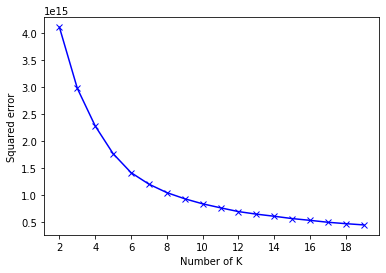

In [5]:
#Finding optimal number of clusters
from sklearn.cluster import KMeans
from matplotlib.ticker import MaxNLocator

cost = []

for i in range(2,20):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(df)

  cost.append(kmeans.inertia_)

plt.plot(range(2,20), cost, 'bx-')
plt.xlabel("Number of K")
plt.ylabel("Squared error")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

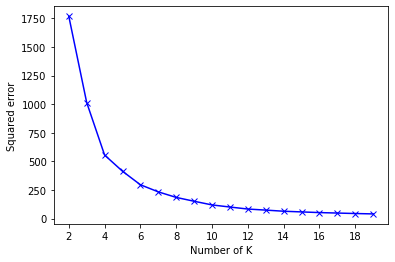

In [6]:
from sklearn.cluster import KMeans
cost = []

for i in range(2,20):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(df2)

  cost.append(kmeans.inertia_)

plt.plot(range(2,20), cost, 'bx-')
plt.xlabel("Number of K")
plt.ylabel("Squared error")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [79]:
from sklearn.metrics import silhouette_score	
# Prepare models	
kmeans = KMeans(n_clusters=5).fit(df)
normalized_kmeans = KMeans(n_clusters=5).fit(df2)

# Print results	
print('kmeans: {}'.format(silhouette_score(df, kmeans.labels_, metric='euclidean')))
print('Cosine kmeans: {}'.format(silhouette_score(df2, normalized_kmeans.labels_, metric='cosine')))

kmeans: 0.4672144477451795
Cosine kmeans: 0.7788076520984483


In [13]:
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(df)
#y_kmeans = kmeans.predict(df)

In [14]:
# df['cluster'] = y_kmeans
# df.head()

In [7]:
normalized_kmeans = KMeans(n_clusters=5, random_state=42).fit(df2)
df['cluster'] = normalized_kmeans.labels_

In [8]:
df.groupby('cluster')['cluster'].count()

cluster
0    30939
1    35988
2    14440
3     5899
4     9086
Name: cluster, dtype: int64

## Cluster Visualization

In [9]:
def prepare_pca(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels   
    return df_matrix

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    return df_matrix

def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=name, opacity=0.5)
    fig.update_traces(marker=dict(size=3))
    fig.show()

def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)
    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

In [13]:
pca_df = prepare_pca(3, df, normalized_kmeans.labels_)
plot_3d(pca_df)

Output hidden; open in https://colab.research.google.com to view.

In [1]:
tsne_3d_df = prepare_tsne(3, df, kmeans.labels_)	
tsne_3d_df['normalized_kmeans'] = normalized_kmeans.labels_	

plot_animation(tsne_3d_df, 'kmeans', 'kmeans')	
plot_animation(tsne_3d_df, 'normalized_kmeans', 'normalized_kmeans')	

NameError: ignored

In [ ]:
plot_3d(tsne_3d_df)

In [ ]:
plot_3d(tsne_3d_df, name='normalized_kmeans')

## Cutomer Characteristics

## Random Forest

In [85]:
df.head()

ORIG_RT  ORIG_AMT  ORIG_TRM  ...  OCC_STAT_P  OCC_STAT_S  cluster
0    2.875  450000.0       180  ...           1           0        3
1    5.500   30000.0       120  ...           1           0        3
2    3.875  115000.0       360  ...           1           0        0
3    5.750   88000.0       360  ...           0           0        0
4    3.500  290000.0       360  ...           1           0        1

[5 rows x 37 columns]

In [86]:
train = df[df['VinYr']<=2012]
test = df[df['VinYr']>=2013]
train.shape, test.shape

((62416, 37), (33936, 37))

In [87]:
train_pct = train.groupby('cluster')['cluster'].count().to_frame(name='count').reset_index()
train_pct['sum'] = 62416
train_pct['percentage'] = (train_pct['count']/train_pct['sum']).round(2)
train_pct[['cluster', 'percentage']]

cluster  percentage
0        0        0.30
1        1        0.36
2        2        0.17
3        3        0.07
4        4        0.10

In [88]:
test_pct = test.groupby('cluster')['cluster'].count().to_frame(name='count').reset_index()
test_pct['sum'] = 33936
test_pct['percentage'] = (test_pct['count']/test_pct['sum']).round(2)
test_pct[['cluster', 'percentage']]

cluster  percentage
0        0        0.36
1        1        0.41
2        2        0.12
3        3        0.04
4        4        0.08

In [89]:
X_train = train.drop('cluster',axis=1)
y_train = train['cluster']
X_test = test.drop('cluster',axis=1)
y_test = test['cluster']

In [90]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report

model = RandomForestClassifier(max_depth=8, random_state=42, n_estimators=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12260
           1       1.00      1.00      1.00     13797
           2       1.00      1.00      1.00      3910
           3       1.00      0.98      0.99      1359
           4       0.99      0.98      0.98      2610

    accuracy                           1.00     33936
   macro avg       1.00      0.99      0.99     33936
weighted avg       1.00      1.00      1.00     33936



In [91]:
d = {
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}
dt_imp = pd.DataFrame(d)
dt_imp = dt_imp.sort_values('Importance', ascending=False)
dt_imp.index = range(len(dt_imp))
(dt_imp['Importance']!=0).sum(), (dt_imp['Importance']==0).sum()

(33, 3)

In [92]:
dt_imp[dt_imp['Importance']==0].Feature

33       MODUPB_CHNG
34       MODTRM_CHNG
35    RELOCATION_FLG
Name: Feature, dtype: object

Text(0.5, 1.0, 'Top 10 Important Features')

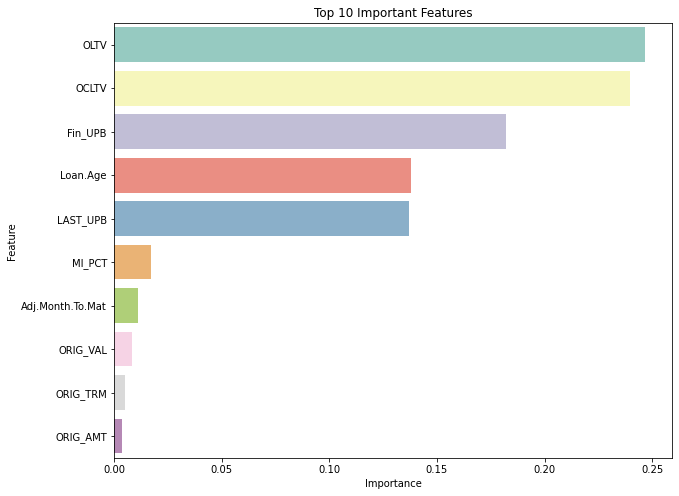

In [93]:
plt.figure(figsize=(10,8))
sns.barplot(data=dt_imp[dt_imp['Importance']!=0][:10], y='Feature', x='Importance', palette='Set3')
plt.title('Top 10 Important Features')

## Correlation Heatmap

In [27]:
def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

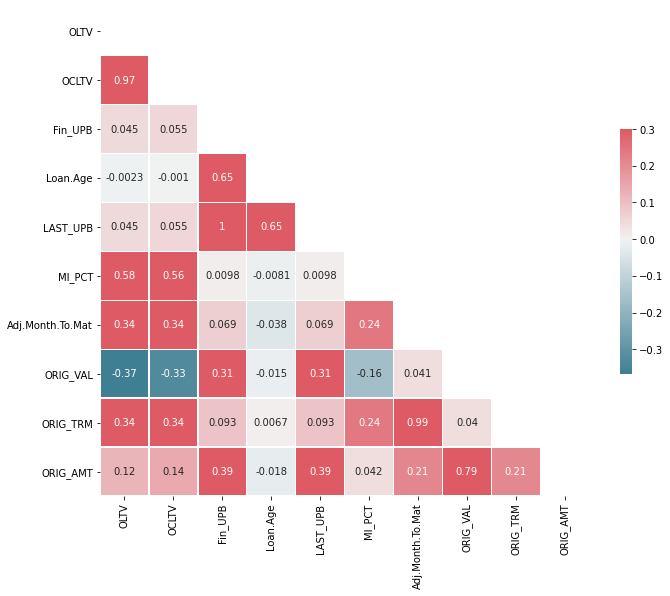

In [28]:
features= dt_imp.sort_values(by='Importance',ascending=False)
features = features.iloc[:10,]
features = features['Feature'].to_list()
corMax = df[features]

plot_corr(corMax)

## PDP plots

In [29]:
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

     |████████████████████████████████| 34.0MB 115kB/s 
     |████████████████████████████████| 13.1MB 334kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758228 sha256=24440a48e057a1f517ecb34b071680f55886852b76dbd285d1eaaa9beaf99982
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [30]:
features= dt_imp.sort_values(by='Importance',ascending=False)
features = features.iloc[:10,]
features = features['Feature'].to_list()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


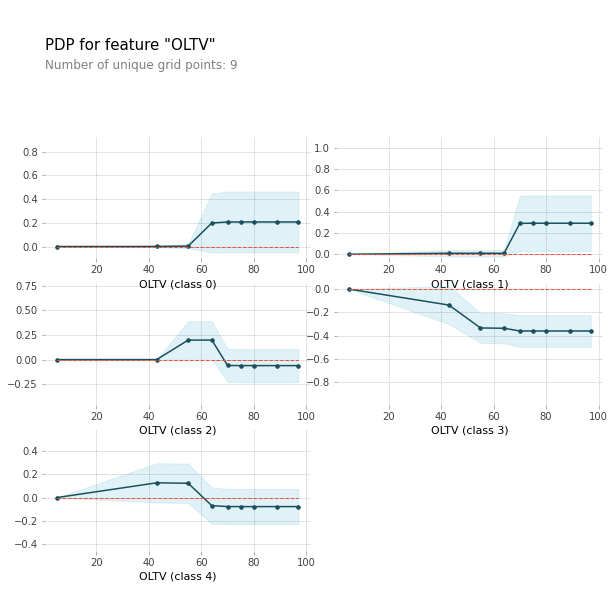

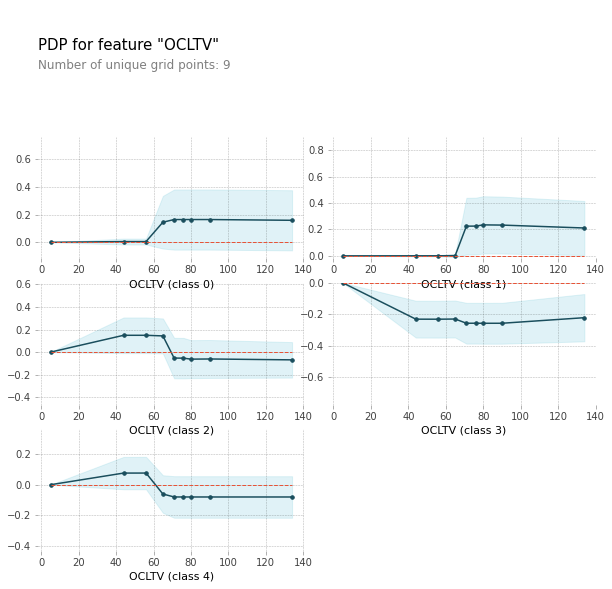

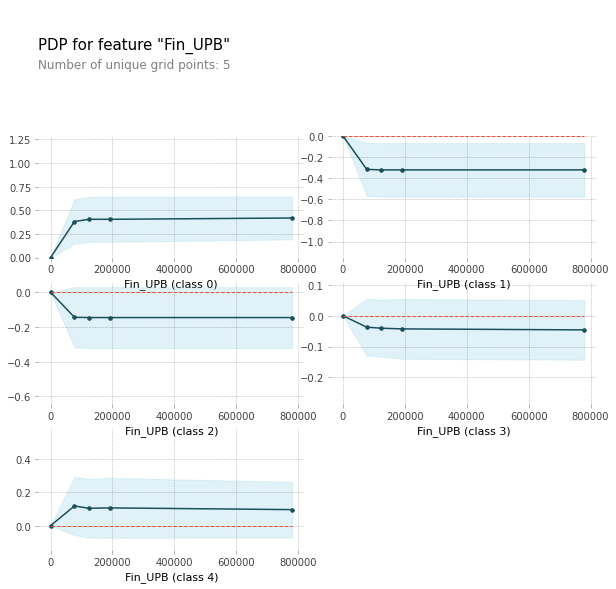

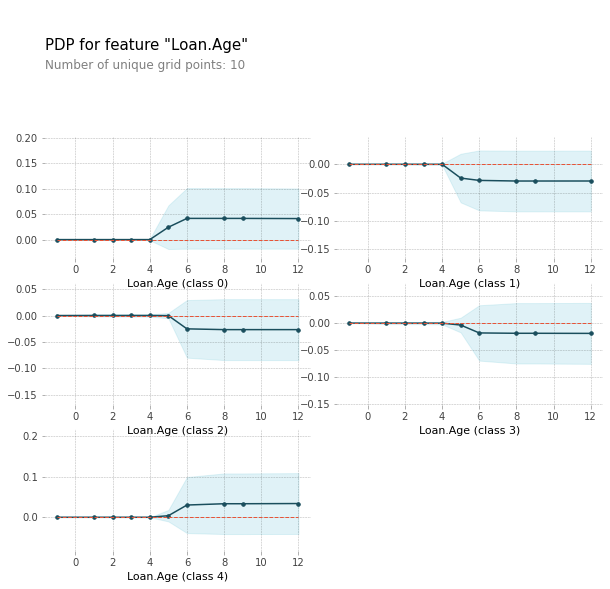

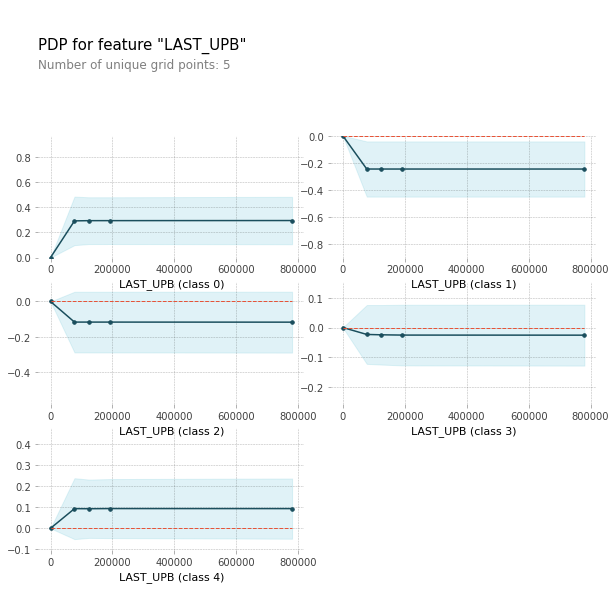

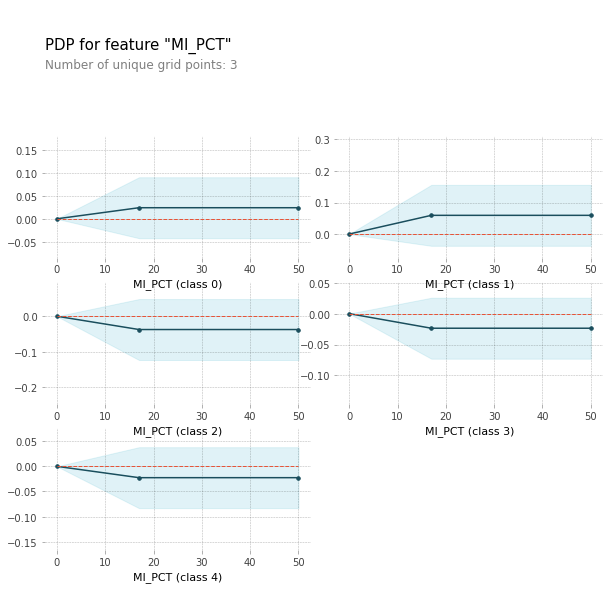

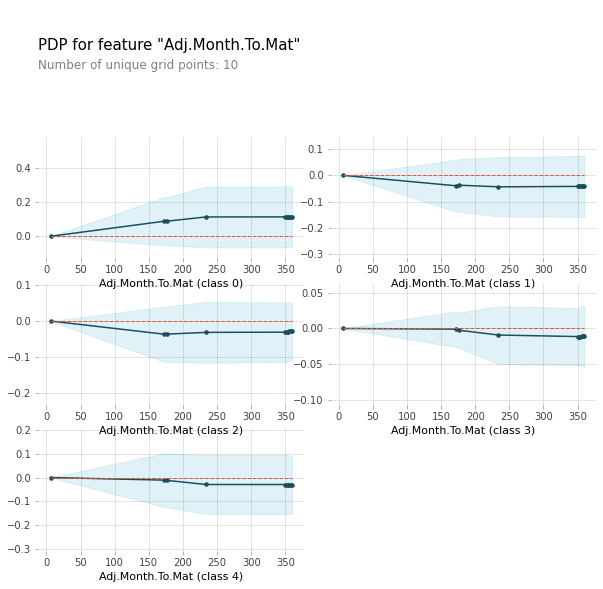

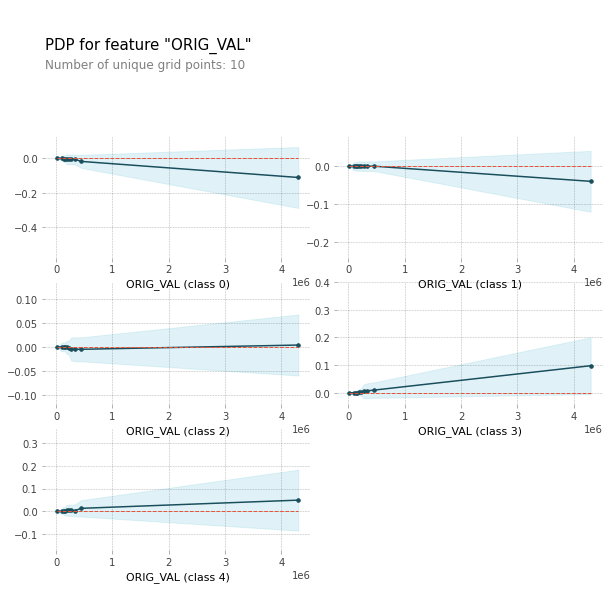

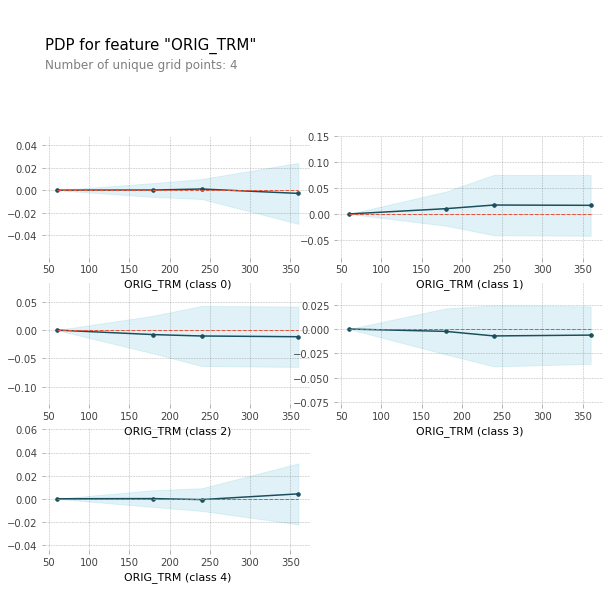

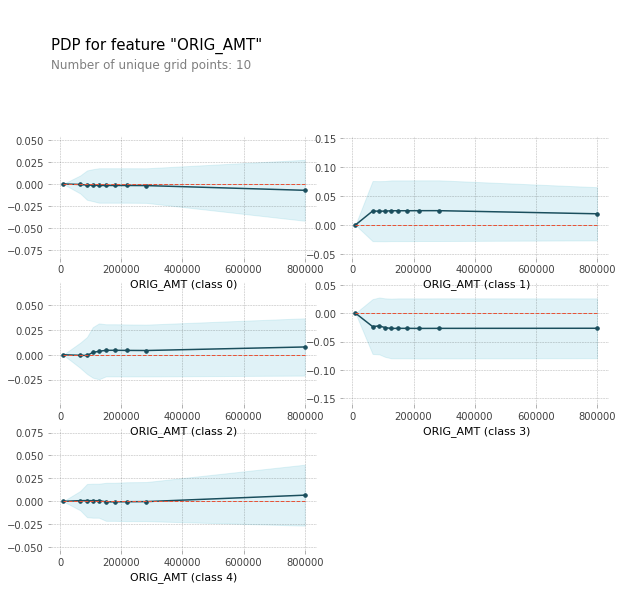

In [31]:
for i in range(len(features)):
  pdp_goals = pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns, feature=features[i])
  pdp.pdp_plot(pdp_goals, features[i], figsize=(10,10), center=True)
  plt.show()

## ICE plots


In [95]:
for i in range(len(features)):
  ice_goals = ice.ice_isolate(model=model, dataset=X_train, model_features=X_train.columns, feature=features[i])
  ice.ice_plot(ice_goals,features[i],figsize=(10,10),plot_lines=True,frac_to_plot=100)
  plt.show()

NameError: ignored

In [69]:
ice_df = ice(data = X_train, column = 'MedInc', predict = est.predict, num_grid_points=10)
ice_df.head

NameError: ignored

In [ ]:
plt.rcParams['figure.figsize'] = 10,8
ice_plot(ice_df, linewidth = .15, cmap=PuOr, alpha = 0.1)

plt.ylabel('y_train')
plt.xlabel('MedInc')
plt.title('ICE Plot of MedInc on Housing Price')
plt.show()

## ALE plots

In [33]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-kpeg88ni/alepython
  Running command git clone -q https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-kpeg88ni/alepython
     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-cp37-none-any.whl size=15021 sha256=79aa100e5f5fc2441039b99e4f651579ede32a19a9152ed2c64764d9ea5bcc6e
  Stored in directory: /tmp/pip-ephem-wheel-cache-qkh0rrjr/wheels/5a/17/29/0b0c478aac3d3ecd61153b9c01e38de8385c33a7d5b8bb9917
Successfully built alepython


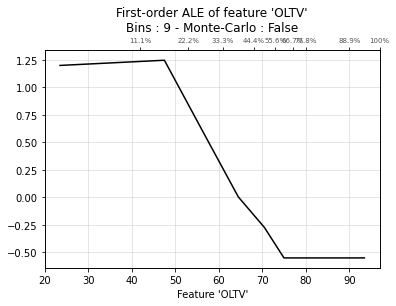

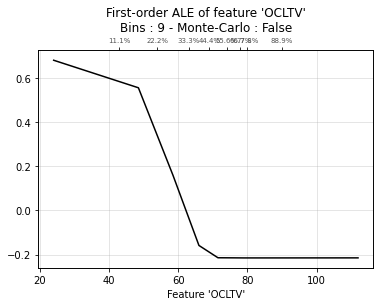

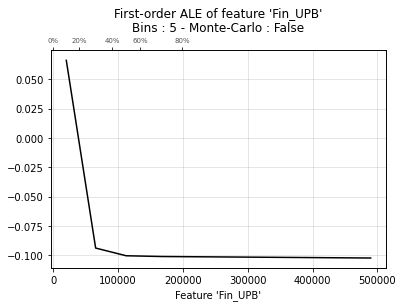

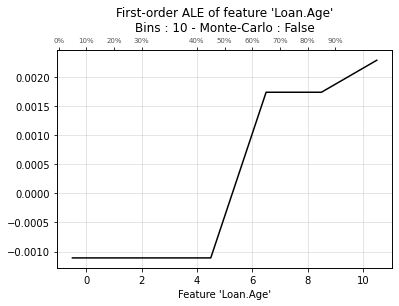

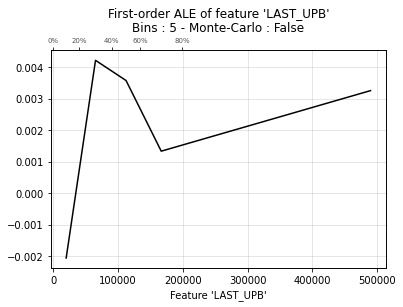

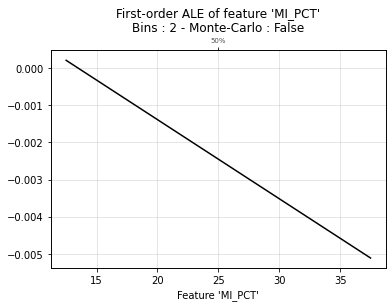

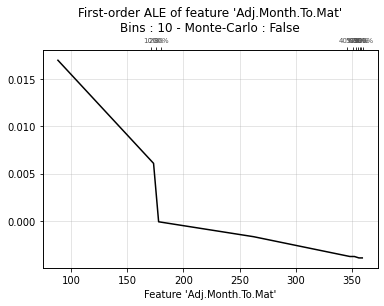

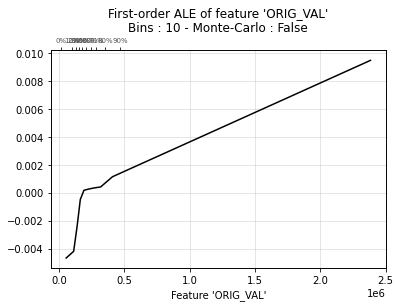

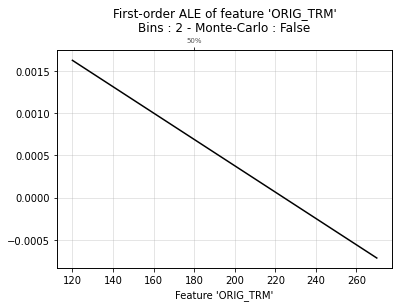

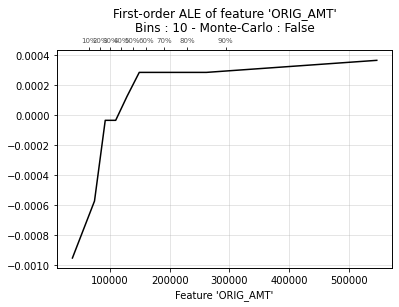

In [34]:
from alepython import ale_plot
for i in range(len(features)):
  ale_plot(model, X_train, features[i])

## LIME

In [52]:
!pip install lime
import lime
import lime.lime_tabular
from sklearn.metrics import classification_report
import lime.explanation

In [57]:
# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['MEDV'], verbose=True, mode='regression')

In [58]:
# Choose the 5th instance and use it to predict the results
j = 5
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=10)

Intercept 1.5741879209361835
Prediction_local [1.04002788]
Right: 0


In [59]:
exp.show_in_notebook(show_table=True)

In [40]:
exp.as_list()

[('PROP_TYP_MH <= 0.00', 0.31632094621589013),
 ('MODTRM_CHNG <= 0.00', 0.2998113825443412),
 ('PROP_TYP_CP <= 0.00', -0.2780162932348118),
 ('58.00 < OLTV <= 73.00', -0.2628430592736321),
 ('MI_PCT <= 0.00', 0.25688374042151424),
 ('NUM_UNIT <= 1.00', 0.23440462399177087),
 ('59.00 < OCLTV <= 74.00', -0.21467839297705127),
 ('Delq.Status <= 0.00', 0.2012465476793994),
 ('Fin_UPB > 111402.47', -0.18197624417830943),
 ('MODUPB_CHNG <= 0.00', 0.16400662525527776)]

In [41]:
j = 10
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=10)

Intercept 1.9787113239232557
Prediction_local [1.33973967]
Right: 2


In [42]:
exp.show_in_notebook(show_table=True)

In [43]:
exp.as_list()

[('RELOCATION_FLG <= 0.00', -0.3147223950841677),
 ('MI_PCT <= 0.00', 0.28082790637817123),
 ('MODTRM_CHNG <= 0.00', -0.21521806388911718),
 ('PROP_TYP_CP <= 0.00', -0.2121775537248693),
 ('58.00 < OLTV <= 73.00', -0.18591967921142113),
 ('59.00 < OCLTV <= 74.00', -0.17580723767895923),
 ('NUM_UNIT <= 1.00', -0.1100039232337202),
 ('Fin_UPB <= 0.00', 0.10191190551195636),
 ('LAST_UPB <= 0.00', 0.10057437501413667),
 ('Loan.Age <= 2.00', 0.09156300977680493)]

In [61]:
j = 50
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=10)

Intercept 0.19941274705076517
Prediction_local [3.39703656]
Right: 4


In [62]:
exp.show_in_notebook(show_table=True)

In [46]:
exp.as_list()

[('73.00 < OLTV <= 80.00', -0.7364200714938705),
 ('74.00 < OCLTV <= 80.00', -0.3731942227694767),
 ('RELOCATION_FLG <= 0.00', -0.3480158824603631),
 ('PROP_TYP_CP <= 0.00', 0.31360015662515883),
 ('PROP_TYP_MH <= 0.00', -0.3015238340023157),
 ('MI_PCT <= 0.00', 0.29953176148511285),
 ('MODTRM_CHNG <= 0.00', 0.27151643735361014),
 ('351.00 < Adj.Month.To.Mat <= 356.00', -0.09631231014444364),
 ('5.00 < Loan.Age <= 7.00', -0.0858991168484981),
 ('180.00 < ORIG_TRM <= 360.00', 0.08434497305502175)]

# SHAP


In [96]:
!pip install shap


In [97]:
import shap
#https://colab.research.google.com/drive/1as0n3ozs4ut7-KbQX-d1NVeP37-E6kkC#scrollTo=dQr-njoGHNAY

In [99]:
# explain the model's predictions on test set using SHAP values
# same syntax works for xgboost, LightGBM, CatBoost, and some scikit-learn models
explainer = shap.TreeExplainer(model)

# shap_values consists of a list of two matrices of dimension samplesize x #features
# The first matrix uses average nr of benign samples as base value
# The second matrix which is used below uses average nr of malignant samples as base value 
shap_values = explainer.shap_values(X_test)


# Interactive visualization of the explanation of the first subject
# in the test set (X_explain).
# It shows the relative contribution of features to get from the base value of malignant
# samples(average value)
# to the output value (1 in case of malignant sample)
# the numbers at the bottom show the actual values for this sample.
shap.initjs() #initialize javascript in cell
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])


In [ ]:
#Interactive visualization of all sample/feature Shapley values
#It is possible to show the relative contribution of individual features for all
# samples on the y-axis as well.
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

In [ ]:
#A summary plot with the shapley value (feature importance) 
shap.summary_plot(shap_values[1], X_test)

In [ ]:
#Same as above, but with violin plots to better see the distribution of shapley values 
shap.summary_plot(shap_values[1], X_test, plot_type="violin")